# **AIDS Virus Infection Prediction**

Nama : Nadhif Fauzil Adhim <br>
NIM  : 22.11.5035

#Import Library

In [1]:
!pip install catboost
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
import optuna

# Import Datasets

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_path = '/content/drive/MyDrive/Big Data & Data Mining/Datasets/AIDS_Classification.csv'
df = pd.read_csv(data_path)

# 1. Datasets Overview

Menampilkan informasi dataset, deskripsi statistik, dan mengecek missing values

In [5]:
print("\n===== Dataset Info =====")
df.info()
print("\n===== Dataset Description =====")
print(df.describe())
print(f"Class Distribution:\n{df['infected'].value_counts(normalize=True)}")


===== Dataset Info =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   time      2139 non-null   int64  
 1   trt       2139 non-null   int64  
 2   age       2139 non-null   int64  
 3   wtkg      2139 non-null   float64
 4   hemo      2139 non-null   int64  
 5   homo      2139 non-null   int64  
 6   drugs     2139 non-null   int64  
 7   karnof    2139 non-null   int64  
 8   oprior    2139 non-null   int64  
 9   z30       2139 non-null   int64  
 10  preanti   2139 non-null   int64  
 11  race      2139 non-null   int64  
 12  gender    2139 non-null   int64  
 13  str2      2139 non-null   int64  
 14  strat     2139 non-null   int64  
 15  symptom   2139 non-null   int64  
 16  treat     2139 non-null   int64  
 17  offtrt    2139 non-null   int64  
 18  cd40      2139 non-null   int64  
 19  cd420     2139 non-null   int64  
 20  cd80

# Cek Missing Value

In [6]:
print("\n===== Checking Missing Values =====")
print(df.isnull().sum())


===== Checking Missing Values =====
time        0
trt         0
age         0
wtkg        0
hemo        0
homo        0
drugs       0
karnof      0
oprior      0
z30         0
preanti     0
race        0
gender      0
str2        0
strat       0
symptom     0
treat       0
offtrt      0
cd40        0
cd420       0
cd80        0
cd820       0
infected    0
dtype: int64


# Rename Kolom Infected menjadi Target

Mengganti nama kolom target agar lebih jelas

In [7]:
df.rename(columns={'infected': 'target'}, inplace=True)

# 2. EXPLORATORY DATA ANALYSIS

Analisis distribusi kelas dan visualisasi hubungan antar fitur

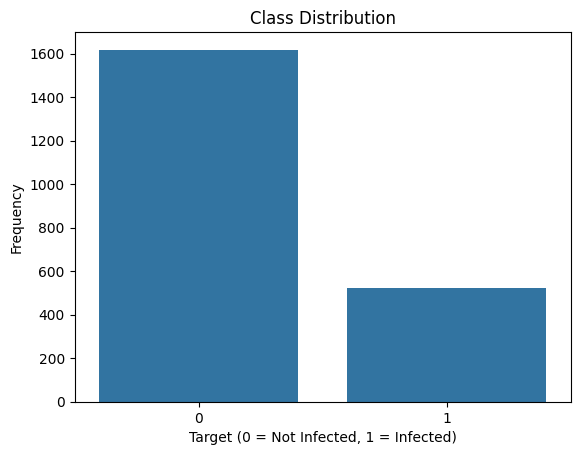

In [8]:
sns.countplot(x='target', data=df)
plt.title('Class Distribution')
plt.xlabel('Target (0 = Not Infected, 1 = Infected)')
plt.ylabel('Frequency')
plt.show()

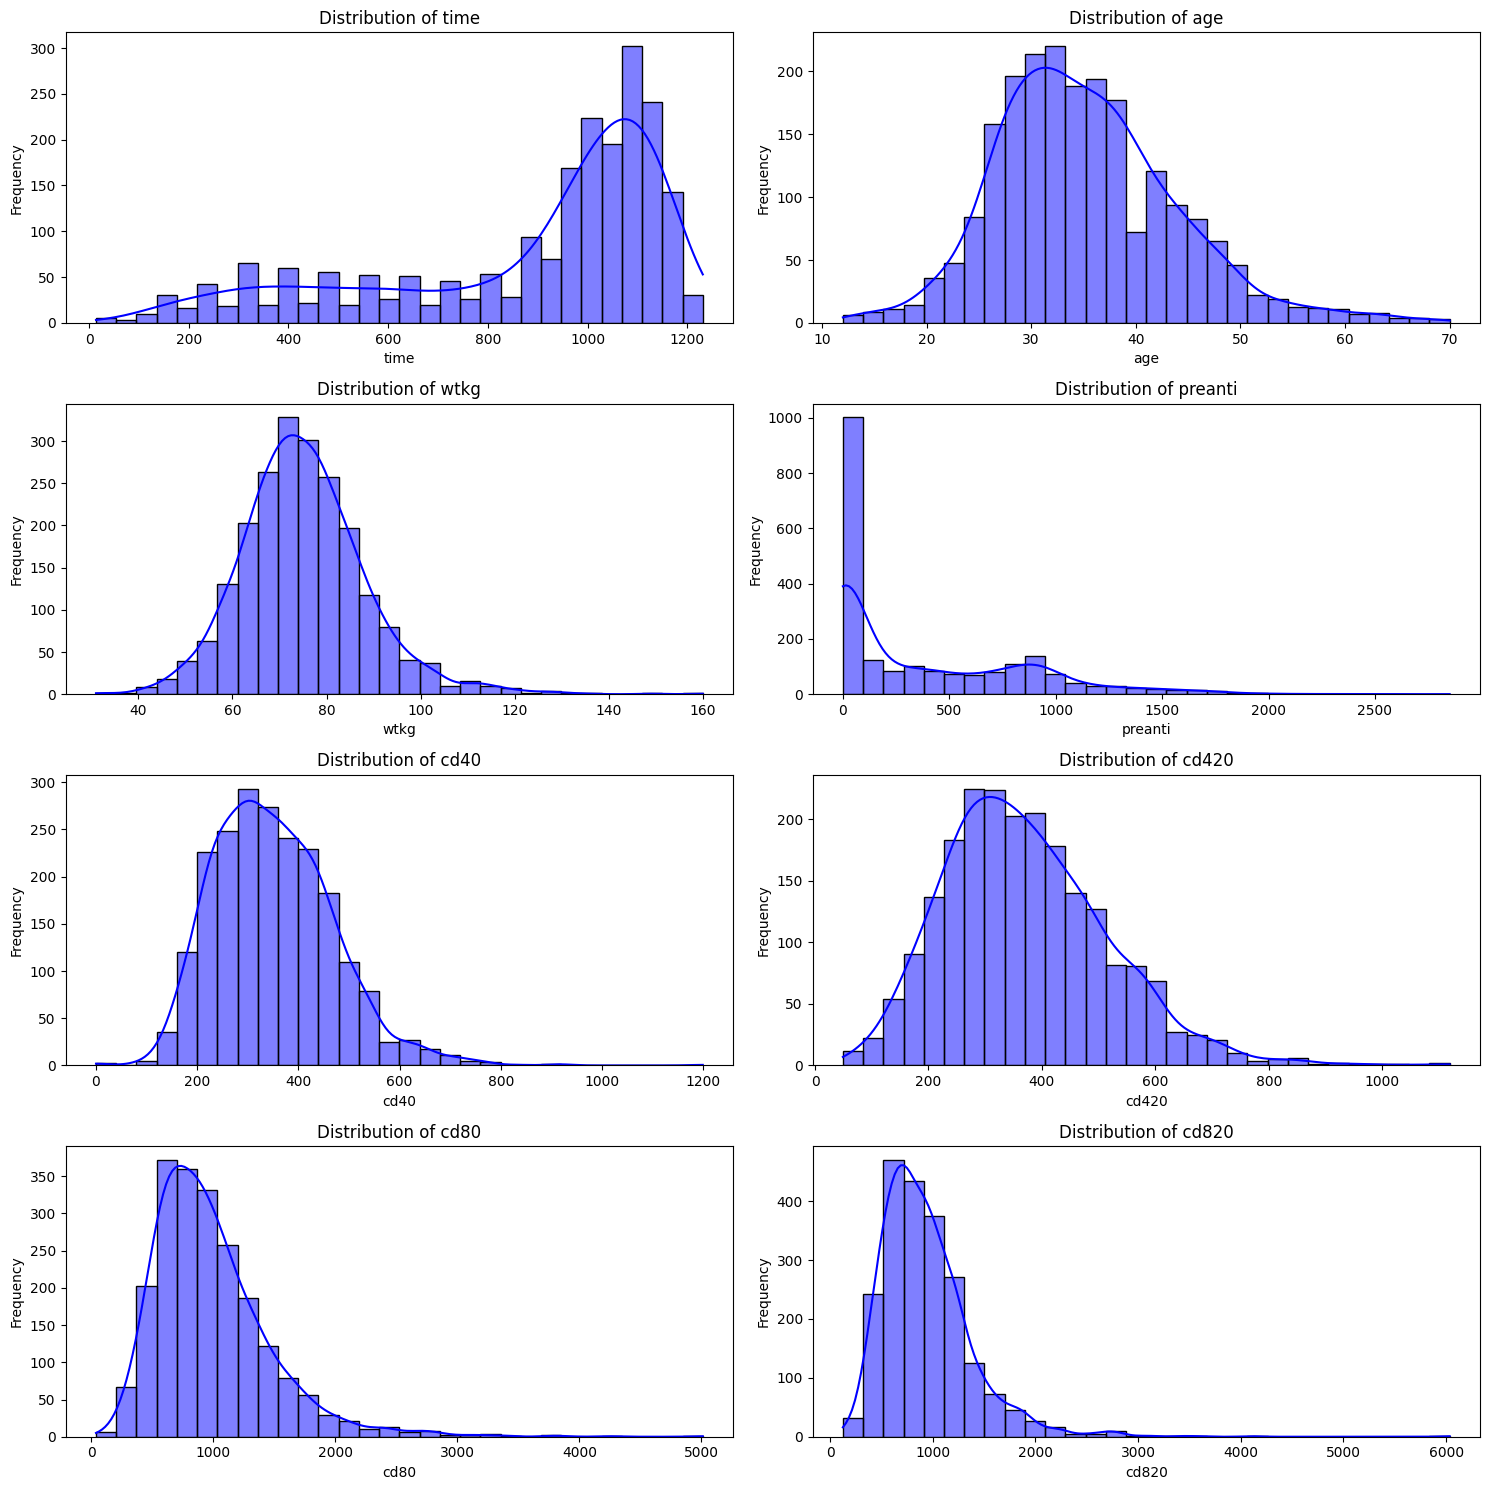

In [9]:
cont_cols = ['time', 'age', 'wtkg', 'preanti', 'cd40', 'cd420', 'cd80', 'cd820']
plt.figure(figsize=(15, 15))
for i, col in enumerate(cont_cols, 1):
    plt.subplot(4, 2, i)
    sns.histplot(df[col], kde=True, bins=30, color='blue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

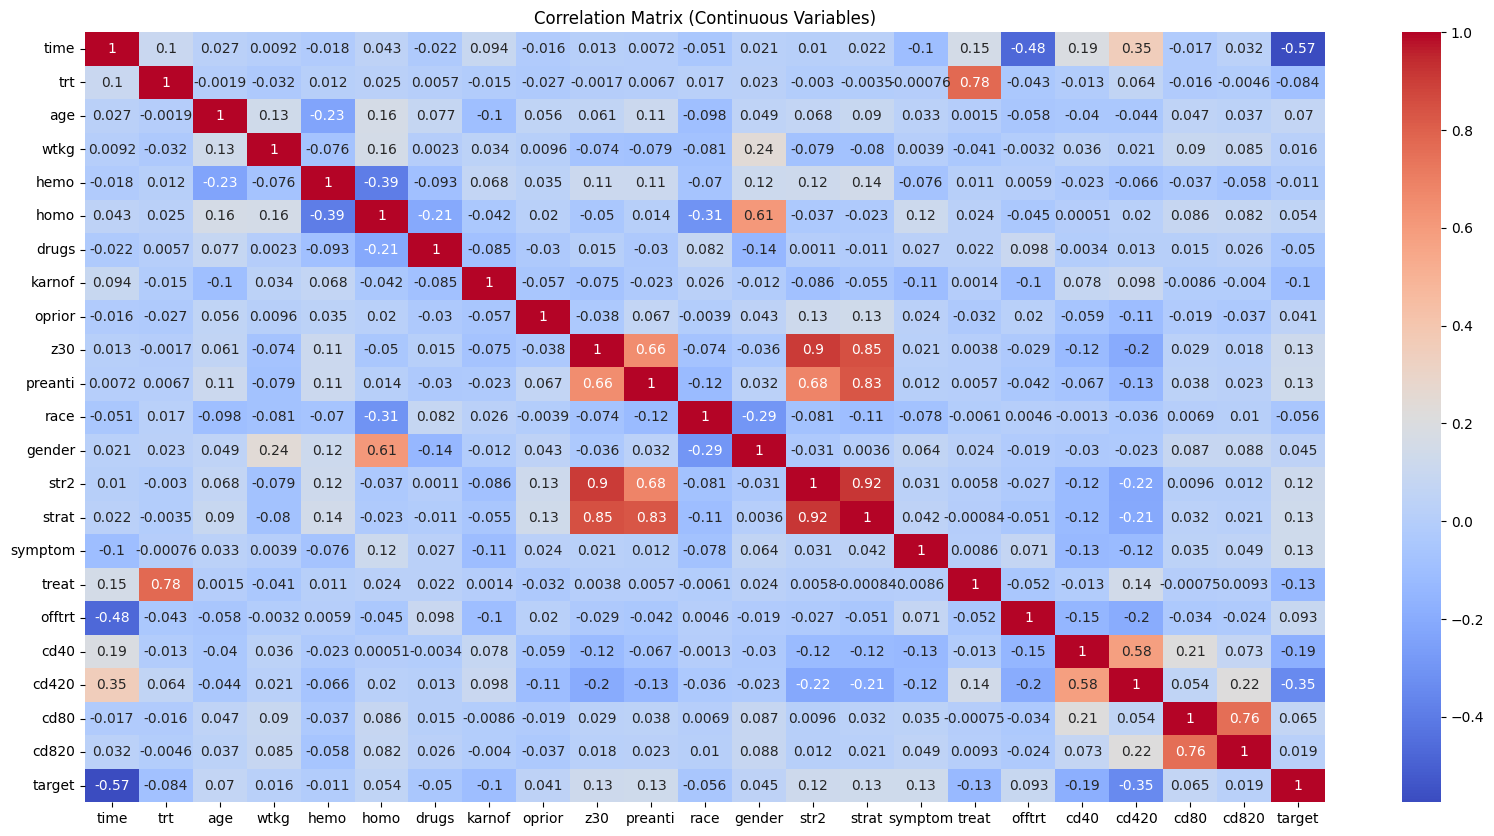

In [10]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True)
plt.title('Correlation Matrix (Continuous Variables)')
plt.show()


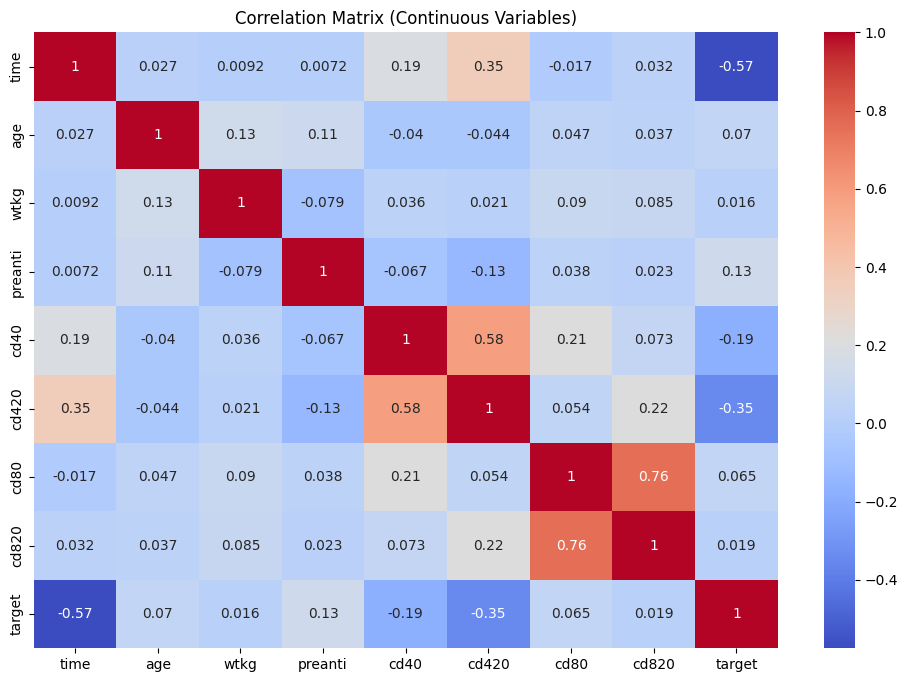

In [11]:
cont_cols = ['time', 'age', 'wtkg', 'preanti', 'cd40', 'cd420', 'cd80', 'cd820','target']
plt.figure(figsize=(12, 8))
sns.heatmap(df[cont_cols].corr(), cmap='coolwarm', annot=True)
plt.title('Correlation Matrix (Continuous Variables)')
plt.show()

# 3. DATA PREPROCESSING

# Convert categorical columns to numerical

In [12]:
categorical_cols = df.select_dtypes(include=['object']).columns
print(f"Categorical Columns: {categorical_cols.tolist()}")
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

Categorical Columns: []


# Define features and target

In [13]:
cont_cols = ['time', 'age', 'wtkg', 'preanti', 'cd40', 'cd420', 'cd80', 'cd820']
X = df[cont_cols]
y = df['target']

Alasan Pemilihan Fitur
* time (Time to failure or censoring):
Fitur ini sangat penting karena mencerminkan waktu hingga kegagalan . Korelasi negatif kuatnya dengan target menunjukkan relevansi dalam memprediksi apakah seseorang terinfeksi AIDS.
* age (Age at baseline):
Usia bisa menjadi faktor risiko utama yang memengaruhi kerentanan terhadap infeksi dan perkembangan penyakit.
* wtkg (Weight at baseline):
Berat badan sering kali mencerminkan kondisi kesehatan umum seseorang. Korelasinya dengan target menunjukkan bahwa ini mungkin relevan dalam klasifikasi infeksi AIDS.
* preanti (Days of pre-175 anti-retroviral therapy):
Fitur ini mencerminkan jumlah hari terapi antiretroviral sebelum waktu tertentu, yang dapat memengaruhi perkembangan infeksi.
* cd40 (CD4 at baseline):
CD4 adalah penanda biologis penting dalam menilai fungsi sistem kekebalan tubuh. Pada pasien HIV/AIDS, CD4 sering digunakan untuk memantau perkembangan penyakit.
* cd420 (CD4 at 20+/-5 weeks):
Sama seperti cd40, ini adalah fitur biologis penting yang dapat memberikan informasi tentang kondisi imunologi setelah terapi atau infeksi berlangsung.
* cd80 (CD8 at baseline):
CD8 adalah penanda sel T sitotoksik yang memainkan peran penting dalam respon imun. Korelasinya dengan target menunjukkan bahwa ini relevan.
* cd820 (CD8 at 20+/-5 weeks):
Sama seperti cd80, fitur ini mencerminkan respon imun setelah beberapa waktu terapi atau perkembangan penyakit.
* target (Is infected with AIDS):
Ini adalah variabel target yang ingin diprediksi, sehingga perlu dimasukkan untuk analisis korelasi.
Alasan Tidak Memilih Fitur Lain
trt, treat, dan offtrt:

Variabel ini adalah indikator perlakuan (treatment) dan tidak langsung mencerminkan karakteristik biologis pasien.
Dalam beberapa analisis, mungkin terlalu bergantung pada perlakuan spesifik dan kurang relevan untuk model prediksi umum.

* hemo, homo, drugs:
Fitur-fitur ini bersifat biner (0 atau 1) dan lebih relevan dalam analisis regresi logistik atau model biner. Mereka mungkin tidak memberikan kontribusi signifikan dalam korelasi numerik.
* race dan gender:
Meskipun penting untuk analisis populasi, fitur ini kurang relevan dalam analisis biologis langsung terkait dengan infeksi AIDS.
* symptom, karnof, str2, dan strat:
Meskipun beberapa di antaranya relevan, seperti symptom (indikator gejala), fitur ini mungkin dianggap berlebihan karena sudah diwakili oleh fitur biologis seperti cd40 atau cd420.

# Balancing dataset menggunakan SMOTE

Menyeimbangkan data menggunakan SMOTE

In [14]:
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [15]:
print("Class distribution after balancing:")
print(pd.Series(y_balanced).value_counts())

Class distribution after balancing:
target
0    1618
1    1618
Name: count, dtype: int64


# Scaling fitur

Melakukan normalisasi fitur menggunakan MinMaxScaler

In [16]:
scaler = MinMaxScaler()
X_balanced = scaler.fit_transform(X_balanced)

# Splitting data untuk Optuna optimization

 Membagi data menjadi train dan test untuk optimasi hyperparameter

In [17]:
x_train, x_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# 4. HYPERPARAMETER OPTIMIZATION MENGGUNAKAN OPTUNA

Menggunakan Optuna untuk mencari hyperparameter terbaik

In [18]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'depth': trial.suggest_int('depth', 1, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'thread_count': -1,
        'loss_function': 'MultiClass',
        'eval_metric': 'Accuracy',
        'verbose': False
    }
    model = CatBoostClassifier(**params)
    model.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=False, early_stopping_rounds=20)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Membuat studi Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n===== Best Parameters =====")
print(study.best_params)

[I 2025-01-15 09:11:38,887] A new study created in memory with name: no-name-697af68d-ffcb-4966-be44-ff25986dda7f


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-01-15 09:11:39,144] Trial 0 finished with value: 0.8765432098765432 and parameters: {'iterations': 398, 'learning_rate': 0.2959464848929471, 'depth': 3, 'l2_leaf_reg': 4.127694908400326, 'border_count': 248}. Best is trial 0 with value: 0.8765432098765432.
[I 2025-01-15 09:11:39,277] Trial 1 finished with value: 0.8688271604938271 and parameters: {'iterations': 354, 'learning_rate': 0.2134691617004075, 'depth': 3, 'l2_leaf_reg': 0.14510544469858908, 'border_count': 182}. Best is trial 0 with value: 0.8765432098765432.
[I 2025-01-15 09:11:39,443] Trial 2 finished with value: 0.8672839506172839 and parameters: {'iterations': 982, 'learning_rate': 0.01347421810646637, 'depth': 5, 'l2_leaf_reg': 0.0034602078107808594, 'border_count': 193}. Best is trial 0 with value: 0.8765432098765432.
[I 2025-01-15 09:11:39,583] Trial 3 finished with value: 0.8734567901234568 and parameters: {'iterations': 179, 'learning_rate': 0.3848883248174833, 'depth': 2, 'l2_leaf_reg': 0.00556822615353, 'bor

# 5. Modeling menggunakan Parameter Terbaik

Melatih model dengan parameter terbaik dari Optuna, Model menggunakan K-FOLD Cross Validation


===== Fold Evaluation =====
Accuracy: 0.9151234567901234
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.87      0.91       331
           1       0.88      0.96      0.92       317

    accuracy                           0.92       648
   macro avg       0.92      0.92      0.92       648
weighted avg       0.92      0.92      0.92       648

Confusion Matrix:

Confusion Matrix:
 [[289  42]
 [ 13 304]]


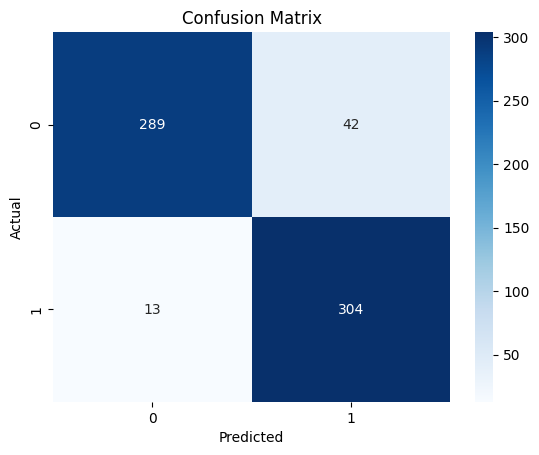


===== Fold Evaluation =====
Accuracy: 0.9227202472952086
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.88      0.92       325
           1       0.89      0.97      0.93       322

    accuracy                           0.92       647
   macro avg       0.93      0.92      0.92       647
weighted avg       0.93      0.92      0.92       647

Confusion Matrix:

Confusion Matrix:
 [[285  40]
 [ 10 312]]


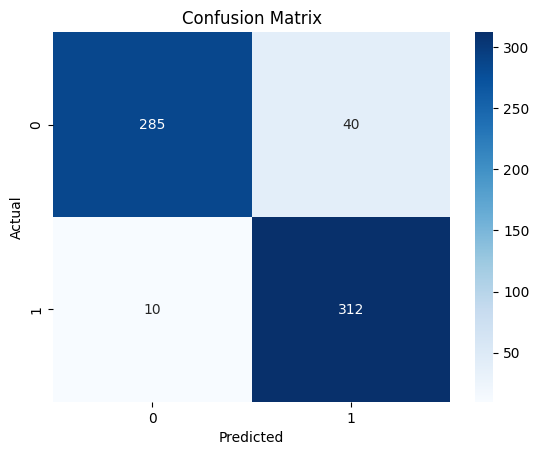


===== Fold Evaluation =====
Accuracy: 0.9072642967542504
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.86      0.90       323
           1       0.87      0.95      0.91       324

    accuracy                           0.91       647
   macro avg       0.91      0.91      0.91       647
weighted avg       0.91      0.91      0.91       647

Confusion Matrix:

Confusion Matrix:
 [[278  45]
 [ 15 309]]


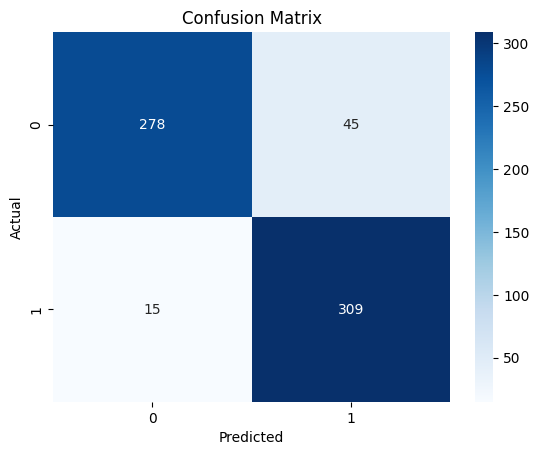


===== Fold Evaluation =====
Accuracy: 0.893353941267388
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.83      0.88       321
           1       0.85      0.96      0.90       326

    accuracy                           0.89       647
   macro avg       0.90      0.89      0.89       647
weighted avg       0.90      0.89      0.89       647

Confusion Matrix:

Confusion Matrix:
 [[265  56]
 [ 13 313]]


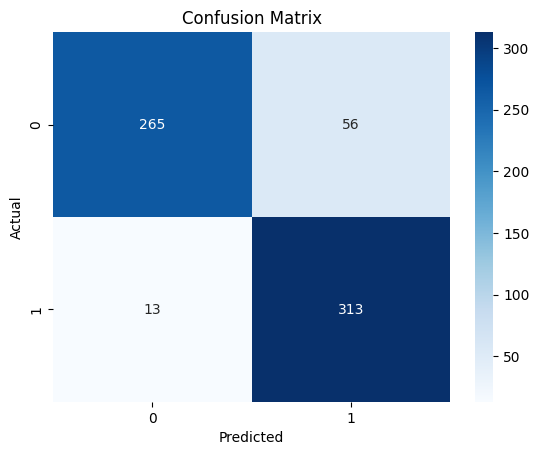


===== Fold Evaluation =====
Accuracy: 0.9289026275115919
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.89      0.93       318
           1       0.90      0.96      0.93       329

    accuracy                           0.93       647
   macro avg       0.93      0.93      0.93       647
weighted avg       0.93      0.93      0.93       647

Confusion Matrix:

Confusion Matrix:
 [[284  34]
 [ 12 317]]


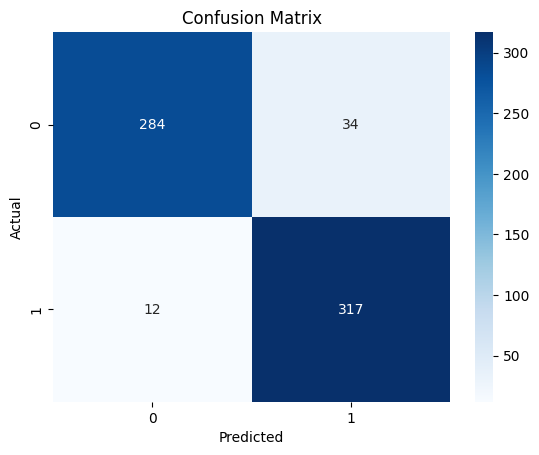


===== Cross-Validation Results =====
Mean Accuracy: 0.9134729139237125
Standard Deviation: 0.012406720078605065


In [19]:
best_params = study.best_params
model = CatBoostClassifier(**best_params, verbose=0, random_seed=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for train_index, test_index in kf.split(X_balanced):
    X_train, X_test = X_balanced[train_index], X_balanced[test_index]
    y_train, y_test = y_balanced[train_index], y_balanced[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    print("\n===== Fold Evaluation =====")
    print("Accuracy:", acc)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n")

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)

    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

print("\n===== Cross-Validation Results =====")
print("Mean Accuracy:", np.mean(accuracies))
print("Standard Deviation:", np.std(accuracies))